In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from IPython.core.pylabtools import figsize
import pymc3 as pm
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


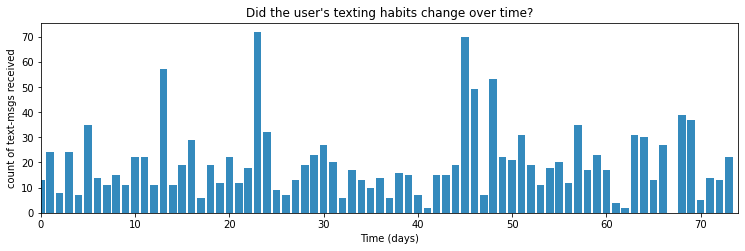

In [3]:
figsize(12.5, 3.5)
data = np.loadtxt("/home/tbrownex/data/Bayes/SMSmessages.csv")
n_data = len(data)
plt.bar(np.arange(n_data), data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_data);

In [17]:
with pm.Model() as model:
    alpha = 1.0/data.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_data - 1)

In [21]:
with model:
    idx = np.arange(n_data)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [30]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=data)

In [34]:
model.basic_RVs

[lambda_1_log__ ~ TransformedDistribution,
 lambda_2_log__ ~ TransformedDistribution,
 tau ~ DiscreteUniform,
 obs ~ Poisson]

In [8]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

/home/tbrownex/tensorflow/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 11 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

(array([1.46297151e-04, 2.92594303e-04, 1.46297151e-04, 2.92594303e-04,
        7.31485757e-05, 7.31485757e-05, 1.46297151e-04, 0.00000000e+00,
        0.00000000e+00, 7.31485757e-05, 7.31485757e-05, 3.65742879e-04,
        0.00000000e+00, 5.85188606e-04, 7.31485757e-05, 1.24352579e-03,
        2.04816012e-03, 3.58428021e-03, 5.63244033e-03, 2.92594303e-02,
        1.86967760e-01, 5.65292193e-01, 4.93899183e-01, 1.38397105e-01,
        2.99177675e-02, 4.02317167e-03, 1.46297151e-04, 7.31485757e-05,
        0.00000000e+00, 1.46297151e-04]),
 array([ 2.77524425,  3.45878456,  4.14232487,  4.82586518,  5.50940548,
         6.19294579,  6.8764861 ,  7.56002641,  8.24356672,  8.92710703,
         9.61064733, 10.29418764, 10.97772795, 11.66126826, 12.34480857,
        13.02834887, 13.71188918, 14.39542949, 15.0789698 , 15.76251011,
        16.44605042, 17.12959072, 17.81313103, 18.49667134, 19.18021165,
        19.86375196, 20.54729226, 21.23083257, 21.91437288, 22.59791319,
        23.28145

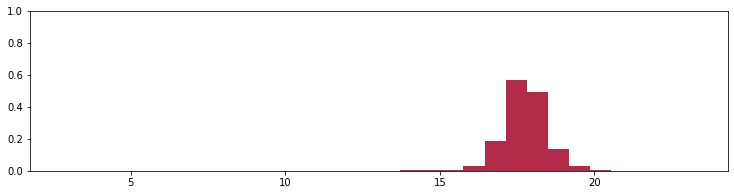

In [41]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)

No handles with labels found to put in legend.


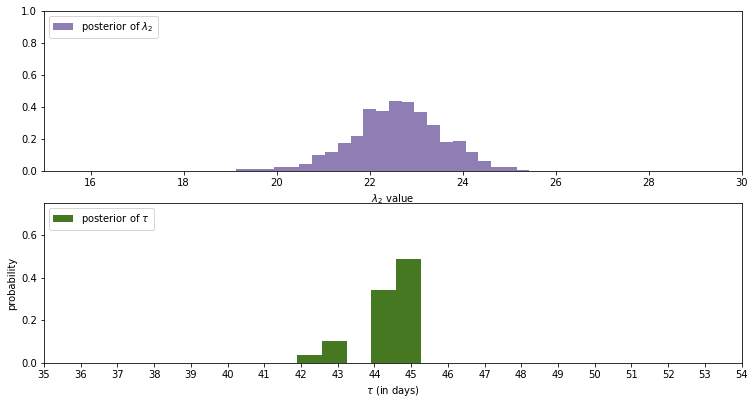

In [42]:
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

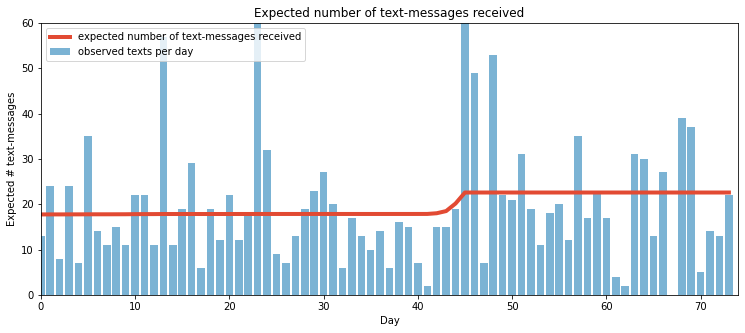

In [43]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_data)
for day in range(0, n_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(data)), data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

In [12]:
tau_samples

array([13, 13, 12, ..., 45, 45, 45])

In [14]:
#dist = pm.Exponential(name='tom', alpha=0.5)

In [4]:
with pm.Model() as model:
    observation = pm.Poisson("obs", 12, observed=data)

In [12]:
type(model)

pymc3.model.Model

In [16]:
model.vars

[]